In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# class FixedUnpickler(pickle.Unpickler):
#     def find_class(self, module, name):
#         # Redirect PosixPath to WindowsPath
#         if module == 'pathlib' and name == 'PosixPath':
#             return WindowsPath
#         return super().find_class(module, name)

# def custom_load(file_path):
#     with open(file_path, 'rb') as f:
#         return FixedUnpickler(f).load()



if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda:0')  # Explicitly use the first GPU
else:
    print("CUDA not available, falling back to CPU.")
    device = torch.device('cpu')

# Your weights file
weights_path = 'yolov5/runs/train/card_number_detector_win2/weights/best.pt'

yolo_model = torch.hub.load('yolov5', 'custom', path=weights_path, source='local', force_reload=True, device=device)


CUDA is available!
Using device: NVIDIA GeForce RTX 3060 Laptop GPU


YOLOv5  2024-11-3 Python-3.12.3 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [2]:
# Load the labels from the Excel file
labels_df = pd.read_excel('APS360_Project_Dataset/dataset5_augmented/labels_augmented.xlsx')

# Assuming your Excel has a single column with labels (1, 2, 3, ...)
# Create a dictionary mapping from numeric labels to corresponding image filenames
image_labels = {f'{int(row[0])}': row['card_num'] for _, row in labels_df.iterrows()}

class CreditCardDataset(Dataset):
    def __init__(self, image_dir, labels_dict, yolo_model, transform=None):
        """
        Args:
            image_dir (str): Directory with all the images
            labels_dict (dict): Dictionary mapping image names to their labels
            yolo_model: Loaded YOLO model for credit card number detection
            transform: Optional transform to be applied on the cropped image
        """
        self.image_dir = image_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.yolo_model = yolo_model
        self.image_filenames = list(labels_dict.keys())
        
    def preprocess_image(self, image_path):
        """
        Load image and use YOLO to crop the credit card number region
        """
        # Read image using cv2
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Could not load image at {image_path}")
        
        # Get YOLO predictions
        results = self.yolo_model(original_image)
        
        # Extract bounding box coordinates
        if len(results.xyxy[0]) > 0:
            # Get the detection with highest confidence
            detection = results.xyxy[0][0]  # [x1, y1, x2, y2, confidence, class]
            x1, y1, x2, y2 = map(int, detection[:4])
            h, w, _ = original_image.shape
            
            # Calculate box width and height
            box_width = x2 - x1
            box_height = y2 - y1

            # Calculate expansion amounts
            expand_x = int(box_width * 0.06)
            expand_y = int(box_height * 0.06)

            # Adjust box coordinates
            x1 = max(0, x1 - int(expand_x * 1.2))  # Expand x1 to the left
            x2 = min(w, x2 + expand_x)  # Expand x2 to the right
            y1 = max(0, y1 - int(expand_y))  # Expand y1 upwards
            y2 = min(h, y2 + expand_y)  # Expand y2 downwards

            # Ensure indices are integers before slicing
            x1 = int(x1)
            x2 = int(x2)
            y1 = int(y1)
            y2 = int(y2)

            # Crop the image
            cropped_image = original_image[y1:y2, x1:x2]
         
            
            # Convert to grayscale
            gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
            
            # Convert to PIL Image
            pil_image = Image.fromarray(gray_image)
            
            return pil_image
        else:
            # If no detection, return the original image converted to grayscale
            print(f"No detection found for {image_path}, skipping image")
            return None

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Returns a tuple (image, label) where label is a list of integers
        """
        try:
            # Get image filename
            img_name = self.image_filenames[idx]
            image_path = os.path.join(self.image_dir, img_name + '.jpg')
            image_path_2 = os.path.join(self.image_dir, img_name + '.png')
            
            # Process image with YOLO and get cropped region
            image = self.preprocess_image(image_path)
            
            if image is None:
                print(f"No valid detection for {img_name}, skipping this image.")
                return None, None
            
            # Apply transforms if any
            if self.transform:
                image = self.transform(image)
            
            # Convert label from integer to list of integers
            label = [int(digit) for digit in str(self.labels_dict[img_name])]
            
            return image, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            print(f"Error processing image {img_name}: {str(e)}")
            raise e
        
def filter_invalid_images(image_dir, labels_dict, yolo_model):
    """
    Filter out invalid images from the dataset without removing them from the local file system.
    
    Args:
        image_dir (str): Directory containing the images.
        labels_dict (dict): Dictionary mapping image names to their labels.
        yolo_model: Loaded YOLO model to validate images.
        
    Returns:
        dict: Updated labels dictionary with only valid image-label pairs.
    """
    valid_labels_dict = {}
    for img_name, label in labels_dict.items():
        # Check for valid extensions
        for ext in ['.jpg', '.png']:
            image_path = os.path.join(image_dir, img_name + ext)
            if os.path.exists(image_path):
                # Check if the image is valid
                original_image = cv2.imread(image_path)
                if original_image is None:
                    print(f"Could not load image at {image_path}, skipping.")
                    break
                results = yolo_model(original_image)
                if len(results.xyxy[0]) > 0:  # Check if YOLO detects any bounding boxes
                    valid_labels_dict[img_name] = label
                    break  # Stop checking extensions after finding a valid one
                else:
                    print(f"No detection found for {image_path}, skipping.")
    return valid_labels_dict

# Directory where your images are located
image_dir = 'APS360_Project_Dataset/dataset5_augmented/img'
valid_labels_dict = filter_invalid_images(image_dir, image_labels, yolo_model)

train_files, val_files = train_test_split(list(valid_labels_dict.keys()), test_size=0.2, random_state=42)

train_labels_dict = {filename: valid_labels_dict[filename] for filename in train_files}
val_labels_dict = {filename: valid_labels_dict[filename] for filename in val_files}

# Define any transformations (if needed)
transform = transforms.Compose([
    transforms.Resize((64, 512)),  # Resize to your model's expected input size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])


# Create datasets with YOLO model
train_dataset = CreditCardDataset(
    image_dir=image_dir,
    labels_dict=train_labels_dict,
    yolo_model=yolo_model,
    transform=transform
)

val_dataset = CreditCardDataset(
    image_dir=image_dir,
    labels_dict=val_labels_dict,
    yolo_model=yolo_model,
    transform=transform
)

def custom_collate_fn(batch):
    images, labels = zip(*batch)
    
    # Pad labels to the maximum length in the batch and convert to tensor
    padded_labels = pad_sequence([torch.tensor(label, dtype=torch.long) for label in labels], 
                                 batch_first=True, padding_value=-1)
    
    # Stack images into a single tensor
    images = torch.stack(images, dim=0)
    
    return images, padded_labels

def decode_predictions(outputs):
    """
    Decode the model outputs into digit sequences
    Args:
        outputs: Model outputs after log_softmax (T, B, C)
    Returns:
        List of predicted number sequences
    """
    # Convert to probabilities and get best indices
    _, max_indices = torch.max(outputs.transpose(0, 1), 2)
    
    # Convert to numpy for processing
    indices = max_indices.cpu().numpy()
    
    # Process each sequence in the batch
    decoded_sequences = []
    for sequence in indices:
        # Remove duplicates and blanks (0)
        current_digit = -1
        current_sequence = []
        
        for digit in sequence:
            if digit != 10 and digit != current_digit:  # Exclude blanks and duplicates
                current_sequence.append(digit)
            current_digit = digit
        
        decoded_sequences.append(current_sequence)
    
    return decoded_sequences

def calculate_accuracy(predictions, targets):
    """
    Calculate character and sequence level accuracy
    Args:
        predictions: List of predicted sequences
        targets: Tensor of target sequences (batch_size, max_length)
    Returns:
        (character_accuracy, sequence_accuracy)
    """
    correct_chars = 0
    total_chars = 0
    correct_sequences = 0
    total_sequences = 0
    
    for pred, target in zip(predictions, targets):
        # Convert target tensor to list, removing padding
        target_seq = [int(x) for x in target if x != -1]
        
        # Character level accuracy
        min_len = min(len(pred), len(target_seq))
        correct_chars += sum(1 for i in range(min_len) if pred[i] == target_seq[i])
        total_chars += max(len(pred), len(target_seq))
        
        # Sequence level accuracy
        if len(pred) == len(target_seq) and all(p == t for p, t in zip(pred, target_seq)):
            correct_sequences += 1
        total_sequences += 1
    
    char_accuracy = correct_chars / total_chars if total_chars > 0 else 0
    seq_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
    
    return char_accuracy, seq_accuracy

No detection found for APS360_Project_Dataset/dataset5_augmented/img\5.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\6.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\7.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\65.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\66.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\67.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\68.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\93.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\115.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\116.jpg, skipping.
No detection found for APS360_Project_Dataset/dataset5_augmented/img\249.jpg, skipping.
No detection found for APS360_Project_Datas

In [ ]:
class CRNN(nn.Module):
    def __init__(self, img_height, num_classes=10, rnn_hidden_size=128):
        super(CRNN, self).__init__()
        
        # CNN Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Calculate feature height after 3 pooling layers
        self.feature_height = img_height // 8
        self.rnn_hidden_size = rnn_hidden_size
        
        # Bidirectional LSTM
        self.rnn = nn.LSTM(128 * self.feature_height, rnn_hidden_size, 
                           bidirectional=True, batch_first=True)
        
        # Final classification layer
        self.fc = nn.Linear(rnn_hidden_size * 2, num_classes + 1)  # +1 for CTC blank
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN Feature Extraction
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        
        # Prepare for RNN
        x = x.permute(0, 3, 1, 2)  # (batch, width, channels, height)
        x = x.contiguous().view(batch_size, -1, 128 * self.feature_height)
        
        # RNN
        x, _ = self.rnn(x)
        
        # Final classification
        x = self.fc(x)  # Shape: (batch, seq_len, num_classes + 1)
        
        # Apply log softmax for CTC loss
        return F.log_softmax(x, dim=2)

CRNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): LSTM(1024, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=11, bias=True)
)

In [14]:
def train_hybrid_model(model, train_loader, val_loader, criterion, lr, 
                      num_epochs, device, scheduler=None):
    best_val_accuracy = 0.0
    history = {
        'train_loss': [], 'train_char_acc': [], 'train_seq_acc': [],
        'val_loss': [], 'val_char_acc': [], 'val_seq_acc': []
    }
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, crnn_model.parameters()), lr=lr)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_char_accuracies = []
        train_seq_accuracies = []
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Skip invalid images
            valid_samples = [(inp, lbl) for inp, lbl in zip(inputs, labels) if inp is not None and lbl is not None]
            if not valid_samples:
                continue
            
            # Unpack valid samples
            inputs, labels = zip(*valid_samples)
            inputs = torch.stack(inputs).to(device)
            labels = torch.stack(labels).to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)  # Shape: (batch, seq_len, num_classes + 1)
            
            # Prepare CTC loss inputs
            batch_size = outputs.size(0)
            input_lengths = torch.full(size=(batch_size,), 
                                    fill_value=outputs.size(1), 
                                    dtype=torch.long,
                                    device=device)
            
            target_lengths = []
            target_labels = []
            for label in labels:
                valid_label = label[label != -1]  # Remove padding
                target_lengths.append(len(valid_label))
                target_labels.extend(valid_label.tolist())
            
            target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
            target_labels = torch.tensor(target_labels, dtype=torch.long, device=device)
            
            # CTC loss expects (seq_len, batch, num_classes)
            outputs = outputs.permute(1, 0, 2)
            
            # Calculate loss
            loss = criterion(outputs, target_labels, input_lengths, target_lengths)
            
            # Calculate accuracy
            predictions = decode_predictions(outputs)
            char_acc, seq_acc = calculate_accuracy(predictions, labels)
            
            # Update metrics
            running_loss += loss.item()
            train_char_accuracies.append(char_acc)
            train_seq_accuracies.append(seq_acc)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
        
        # Log training metrics for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_char_acc = sum(train_char_accuracies) / len(train_char_accuracies)
        epoch_train_seq_acc = sum(train_seq_accuracies) / len(train_seq_accuracies)
        history['train_loss'].append(epoch_train_loss)
        history['train_char_acc'].append(epoch_train_char_acc)
        history['train_seq_acc'].append(epoch_train_seq_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_char_accuracies = []
        val_seq_accuracies = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Skip invalid images
                valid_samples = [(inp, lbl) for inp, lbl in zip(inputs, labels) if inp is not None and lbl is not None]
                if not valid_samples:
                    continue
                
                # Unpack valid samples
                inputs, labels = zip(*valid_samples)
                inputs = torch.stack(inputs).to(device)
                labels = torch.stack(labels).to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Prepare CTC loss inputs
                batch_size = outputs.size(0)
                input_lengths = torch.full(size=(batch_size,), 
                                        fill_value=outputs.size(1), 
                                        dtype=torch.long,
                                        device=device)
                
                target_lengths = []
                target_labels = []
                for label in labels:
                    valid_label = label[label != -1]  # Remove padding
                    target_lengths.append(len(valid_label))
                    target_labels.extend(valid_label.tolist())
                
                target_lengths = torch.tensor(target_lengths, dtype=torch.long, device=device)
                target_labels = torch.tensor(target_labels, dtype=torch.long, device=device)
                
                # CTC loss expects (seq_len, batch, num_classes)
                outputs = outputs.permute(1, 0, 2)
                
                # Calculate loss
                val_loss = criterion(outputs, target_labels, input_lengths, target_lengths)
                val_running_loss += val_loss.item()
                
                # Calculate accuracy
                predictions = decode_predictions(outputs)
                val_char_acc, val_seq_acc = calculate_accuracy(predictions, labels)
                val_char_accuracies.append(val_char_acc)
                val_seq_accuracies.append(val_seq_acc)
        
        # Log validation metrics for the epoch
        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_char_acc = sum(val_char_accuracies) / len(val_char_accuracies)
        epoch_val_seq_acc = sum(val_seq_accuracies) / len(val_seq_accuracies)
        
        history['val_loss'].append(epoch_val_loss)
        history['val_char_acc'].append(epoch_val_char_acc)
        history['val_seq_acc'].append(epoch_val_seq_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Char Acc: {epoch_train_char_acc:.4f}, Train Seq Acc: {epoch_train_seq_acc:.4f}, ')
        print(f'               '
              f'Val Loss: {epoch_val_loss:.4f}, Val Char Acc: {epoch_val_char_acc:.4f}, Val Seq Acc: {epoch_val_seq_acc:.4f}')
        
        # Checkpoint the best model
        if epoch_val_seq_acc > best_val_accuracy:
            best_val_accuracy = epoch_val_seq_acc
            best_model_wts = model.state_dict()
        
        # Step the scheduler if provided
        if scheduler:
            scheduler.step(epoch_val_loss)
        if epoch == 40:
            lr = lr / 10   
        if epoch == 60:   
            lr = lr / 10      
    
    model.load_state_dict(best_model_wts)
    return history


In [15]:
# Update the DataLoader to use the custom collate function
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, collate_fn=custom_collate_fn)

# Instantiate the CRNN model
crnn_model = CRNN(img_height=64, num_classes=10)  # Adjust `img_height` to match your input image height
crnn_model.to(device)

# Initialize CTC loss
criterion = nn.CTCLoss(blank=10, reduction='mean')

# Initialize optimizer with learning rate scheduling
lr = 0.001

# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, min_lr=0.001)

# Training configuration
num_epochs = 80
best_val_accuracy = 0.0

print("Starting training...")
print(f"Training device: {device}")
print(f"Initial learning rate: {lr}")
print(f"Number of epochs: {num_epochs}")

# Start training
history = train_hybrid_model(
    model=crnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    lr=lr,
    num_epochs=num_epochs,
    device=device,
    scheduler=None
)

Starting training...
Training device: cuda:0
Initial learning rate: 0.001
Number of epochs: 80
Epoch [1/80], Train Loss: 2.5782, Train Char Acc: 0.0041, Train Seq Acc: 0.0000, 
               Val Loss: 2.3542, Val Char Acc: 0.0000, Val Seq Acc: 0.0000
Epoch [2/80], Train Loss: 2.1591, Train Char Acc: 0.0000, Train Seq Acc: 0.0000, 
               Val Loss: 2.3661, Val Char Acc: 0.0000, Val Seq Acc: 0.0000
Epoch [3/80], Train Loss: 2.0768, Train Char Acc: 0.0000, Train Seq Acc: 0.0000, 
               Val Loss: 2.2008, Val Char Acc: 0.0000, Val Seq Acc: 0.0000
Epoch [4/80], Train Loss: 1.9806, Train Char Acc: 0.0000, Train Seq Acc: 0.0000, 
               Val Loss: 1.9643, Val Char Acc: 0.0000, Val Seq Acc: 0.0000
Epoch [5/80], Train Loss: 1.8521, Train Char Acc: 0.0073, Train Seq Acc: 0.0000, 
               Val Loss: 1.7752, Val Char Acc: 0.0441, Val Seq Acc: 0.0000
Epoch [6/80], Train Loss: 1.7441, Train Char Acc: 0.0476, Train Seq Acc: 0.0000, 
               Val Loss: 1.7299, Val C

In [16]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.__version__)


True
11.8
2.5.1+cu118


In [17]:
# import matplotlib.pyplot as plt
# %matplotlib inline


# # Function to display images in a grid
# def show_images(images, labels, n_cols=4):
#     n_images = len(images)
#     n_rows = (n_images // n_cols) + (n_images % n_cols > 0)
    
#     plt.figure(figsize=(3, n_rows * 3))
    
#     for idx in range(n_images):
#         plt.subplot(n_rows, n_cols, idx + 1)
#         plt.imshow(images[idx].permute(1, 2, 0), cmap='gray')  # Convert to (H, W, C) format
#         plt.title(f'Label: {labels[idx]}')
#         plt.axis('off')  # Hide axes
        
#     plt.tight_layout()
#     plt.show()
# # 
# # Iterate through the train_loader to collect all images
# all_images = []
# all_labels = []

# for inputs, targets in train_loader:
#     all_images.extend(inputs)  # Extend the list with the batch of images
#     all_labels.extend(targets.numpy())  # Extend the list with the batch of labels

# # Show all images in the training set
# show_images(all_images, all_labels, n_cols=1)

YOLO Predictions: [tensor([[111.48096, 207.95934, 510.41385, 238.07155,   0.81766,   0.00000]], device='cuda:0')]


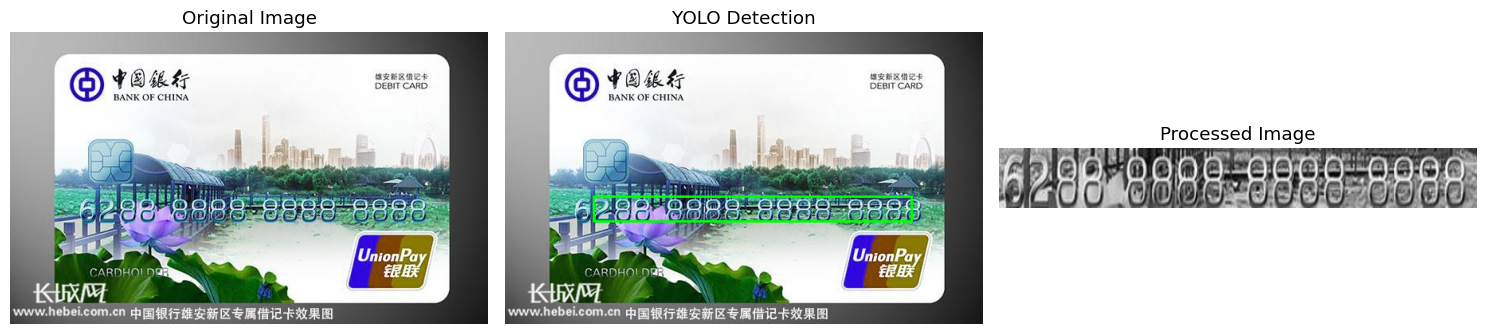

Label: 6288888888888888


In [18]:
def visualize_preprocessing(dataset, index):
    """
    Visualize the original image, YOLO detection, and final processed image
    """
    import matplotlib.pyplot as plt
    
    # Get original image path
    img_name = dataset.image_filenames[index]
    image_path = os.path.normpath(os.path.join(dataset.image_dir, img_name + '.jpg')).replace("\\", "/")
    
    # Read original image
    original_image = cv2.imread(image_path)
    
    # Get YOLO predictions
    results = dataset.yolo_model(original_image)
    print("YOLO Predictions:", results.xyxy)
    
    # Create a copy for drawing
    detection_image = original_image.copy()
    
    # Draw detection box
    if len(results.xyxy[0]) > 0:
        detection = results.xyxy[0][0]
        x1, y1, x2, y2 = map(int, detection[:4])
        cv2.rectangle(detection_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Get processed image
    processed_image, label = dataset[index]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(detection_image)
    axes[1].set_title('YOLO Detection')
    axes[1].axis('off')
    
    # Convert tensor to numpy for visualization
    processed_np = processed_image.squeeze().numpy()
    axes[2].imshow(processed_np, cmap='gray')
    axes[2].set_title('Processed Image')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Label: {''.join(map(str, label.tolist()))}")
    
visualize_preprocessing(train_dataset, 34)

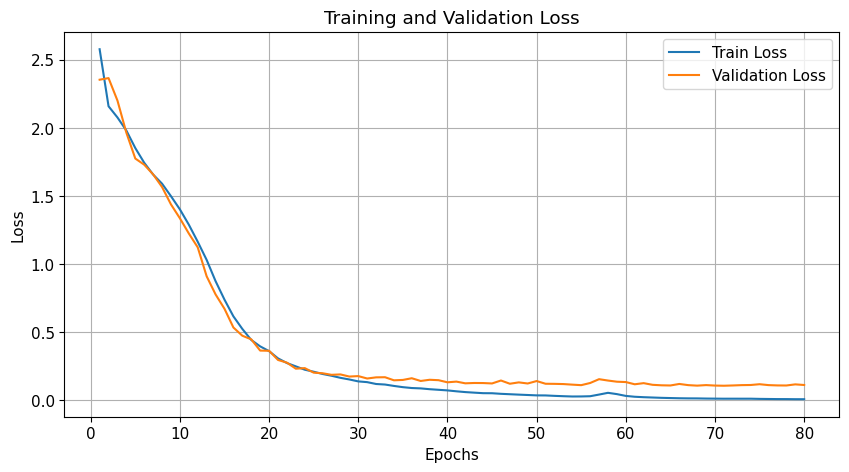

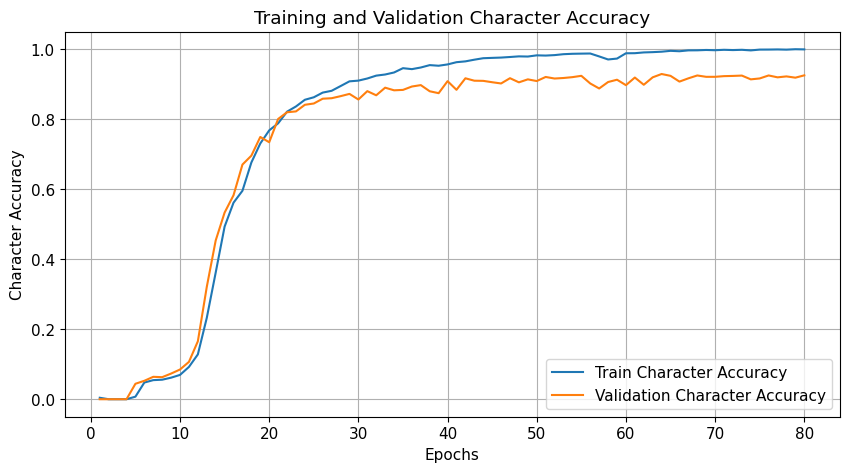

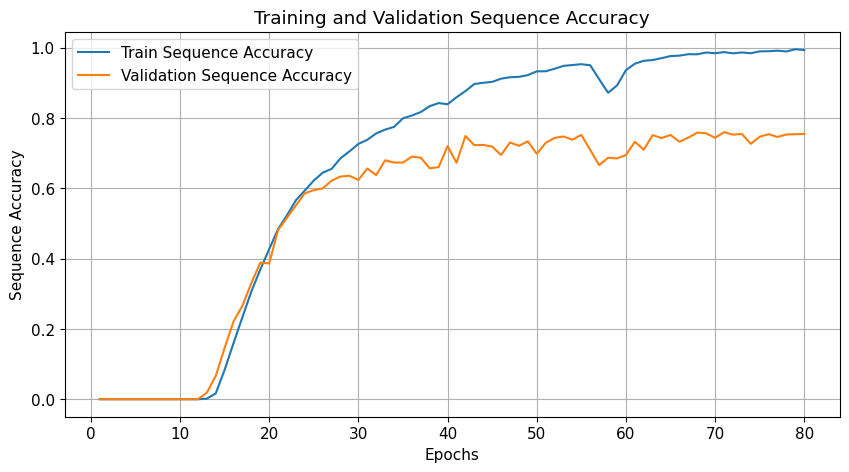

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    epochs = range(1, len(history['train_char_acc']) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_char_acc'], label='Train Character Accuracy')
    plt.plot(epochs, history['val_char_acc'], label='Validation Character Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Character Accuracy')
    plt.title('Training and Validation Character Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_seq_acc'], label='Train Sequence Accuracy')
    plt.plot(epochs, history['val_seq_acc'], label='Validation Sequence Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Sequence Accuracy')
    plt.title('Training and Validation Sequence Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot
plot_history(history)

In [ ]:
# # Save the model
# model_save_path = "crnn_model_valcharacc92_valseqacc75.pth"  # Define the file path
# torch.save(crnn_model.state_dict(), model_save_path)  # Save the model's state_dict
# print(f"Model saved to {model_save_path}")

Model saved to crnn_model_valcharacc92_valseqacc75.pth
